In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.__version__, np.__version__

('2.1.1+cu121', '1.26.2')

In [11]:
# !wget 
import os
def fetch_dataset():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    local_file = os.path.join(os.getcwd(), url.split('/')[-1])
    vocab = lambda text: "".join(sorted(list(set(text))))
    if os.path.exists(local_file):
        with open(local_file, 'r') as f:
            data = f.read()
            return data, len(vocab(data))
    else:
        response = requests.get(url)
        with open(local_file, 'w') as f:
            f.write(response.text)
        return response.text, len(vocab(data))
        
dataset, vocab_size = fetch_dataset()
# print("dataset:\t", dataset[:100])
print("STATS")
print("vocab size: ", vocab_size)

STATS
vocab size:  65


In [14]:
atoi = {ch:i for i,ch in enumerate(chars)}
itoa = {i:ch for i, ch in enumerate(chars)}

encode = lambda s: [atoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itoa[i] for i in l]) # decoder: take a list of integers, output a string

n1 = int(0.8 * len(dataset))
n2 = int(0.9 * len(dataset))
block_size = 16

encode("manan")

[51, 39, 52, 39, 52]

In [23]:


def markov_split(dset, block_size=32): # using sliding window, a bit too slow,
    def sliding_window(dataset):
        x = []
        y = []
        window = [itoa[0]] * block_size
        for i in range(len(dataset)-block_size):
            X = window[1:] + [dataset[i]]
            Y = dataset[i+1]
            x.append(X)
            y.append(Y)
            # res.append((X, Y))
            window = X
        return x, y

    return {
        "train": sliding_window(dataset[:n1]),
        "val": sliding_window(dataset[n1:n2]),
        "test": sliding_window(dataset[n2:]),

    }[dset]

zip(markov_split("train"))[:3]

([['\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   'F'],
  ['\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   'F',
   'i'],
  ['\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   '\n',
   'F',
   'i',
   'r']],
 ['i', 'r', 's'])

In [21]:
batches = 4
def seq_token_pairs_split(dset, block_size=16): # infinite mini-batches, pair tokenizer
    def mini_batches(text):
        data = torch.tensor(encode(text), dtype=torch.long)
        ix = torch.randint(len(data)-block_size, (batches,))
        x = torch.stack([data[i:i+block_size] for i in ix])
        y = torch.stack([data[i+1:i+block_size+1] for i in ix])
        return x, y
    return {
        "train": mini_batches(dataset[:n1]),
        "test": mini_batches(dataset[n1:n2]),
        "val": mini_batches(dataset[n2:]),
    }[dset]

infinite_pair("train")

(tensor([[ 1, 51, 63,  1, 51, 53, 58, 46, 43, 56,  0, 16, 53, 43, 57,  1, 52, 53,
          58,  1, 39, 54, 54, 56, 53, 60, 43,  1, 51, 43,  1, 44],
         [ 1, 51, 63, 57, 43, 50, 44,  2,  0, 27,  1, 58, 46, 39, 58,  1, 21,  1,
          61, 43, 56, 43,  1, 39,  1, 51, 53, 41, 49, 43, 56, 63],
         [46, 53, 50, 63,  1, 28, 39, 59, 50,  6,  1, 58, 46, 43, 63,  1, 50, 53,
          60, 43,  1, 46, 47, 57,  1, 45, 56, 39, 41, 43,  1, 40],
         [49, 47, 52, 42, 52, 43, 57, 57,  1, 39, 58,  1, 51, 63,  1, 46, 39, 52,
          42,  0, 32, 46, 39, 58,  1, 63, 53, 59, 56,  1, 43, 57]]),
 tensor([[51, 63,  1, 51, 53, 58, 46, 43, 56,  0, 16, 53, 43, 57,  1, 52, 53, 58,
           1, 39, 54, 54, 56, 53, 60, 43,  1, 51, 43,  1, 44, 59],
         [51, 63, 57, 43, 50, 44,  2,  0, 27,  1, 58, 46, 39, 58,  1, 21,  1, 61,
          43, 56, 43,  1, 39,  1, 51, 53, 41, 49, 43, 56, 63,  1],
         [53, 50, 63,  1, 28, 39, 59, 50,  6,  1, 58, 46, 43, 63,  1, 50, 53, 60,
          43,  1, 46, 

In [7]:
import torch.nn.functional as F
# basic bigram model

W = torch.randn((vocab_size, vocab_size), dtype=torch.float64)
W.requires_grad = True
# x_enc = C[X]
# x_enc[0]
epoch = 10000
losses = []

optimizer = torch.optim.AdamW([W], lr=1e-3)



In [ ]:
for step in range(epoch):
    X, Y = create_dset("train")
 
    logits = W[X]
    counts = logits.exp() # equivalent N
    probs = counts / counts.sum(1, keepdim=True) 

    B, T, C = logits.shape
    logits = logits.view(B*T, C)
    Y = Y.view(B*T)
    
    
    loss = F.cross_entropy(logits,Y)
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

    if step % 500 == 1:
        print(f"{step=}/{epoch} | loss: {loss:6.4f}|")



step=1/10000 | loss: 4.7188|
step=501/10000 | loss: 4.5185|
step=1001/10000 | loss: 3.8916|
step=1501/10000 | loss: 3.7725|
step=2001/10000 | loss: 3.5418|


In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()
losses[-1], W


In [ ]:
@torch.no_grad()
def compute_loss(dset):
    X, Y = create_dset(dset)
    
    logits = W[X]
    B, T, C = logits.shape
    logits = logits.view(B*T, C)
    Y = Y.view(B*T)

    loss = F.cross_entropy(logits[i],Y[i])    
    return loss

compute_loss("val"), compute_loss("test")

In [ ]:
@torch.inference_mode()
def generate(dset, idx, max_tokens):
    # X, Y = create_dset(dset)


    for _ in range(max_tokens):
        logits = W[idx]
        logits = logits[:, -1, :] 

        probs = F.softmax(logits, dim=-1)        
        idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        # print(probs.view(-1), idx, idx_next)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


decode(generate("test", torch.zeros((1,1), dtype=torch.int64), 500).numpy()[0])
    

In [7]:
a = torch.empty((4, 27))
b = torch.empty((4, 27))
torch.stack((a, b), dim=1).view(4,-1)[:, 0] == torch.cat((a,b), dim=1)[:, 0]

tensor([True, True, True, True])

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class BigramModel(nn.Module):
    def __init__(self):
        self.emb = nn.Parameter(nn.Embedding(vocab_size, vocab_size))

    def forward(self, idx, targets=None):
        logits = self.emb(idx)
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(idx, targets)
            return logits, loss
        return logits, None

    @torch.inference_mode()
    def generate(max_tokens):
        idx = torch.zeros((0,0))
        for _ in max_tokens: 
            logits = self.emb(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.stack((idx, idx_next), dim=1).view(batches,-1)
        return decode(idx.numpy())
    

In [10]:
epoch = 500
model = BigramModel()
losses = []
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
for step in range(epoch):
    X, Y = create_dset("train")
    logits, loss = model(X, Y)        
    optimizer.zero_grad(set_to_none=True)
    
    loss.backward()
    
    optimizer.step()
    losses.append(loss.item())


plt.plot(losses)

AttributeError: 'Embedding' object has no attribute 'detach'

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        n_embd = 1000
        self.emb = nn.Embedding(vocab_size, vocab_size)
        self.l1 = nn.Linear(vocab_size, n_embd)
        self.bn = nn.BatchNorm1d(n_embd, affine=True)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(n_embd, vocab_size)

        self.model = nn.Sequential(
            self.emb,
            self.l1,
            self.bn,
            self.tanh,
            self.l2
        )
        
    def forward(self, idx, targets = None):
        embed = self.emb(idx)
        track_running_stats=True 
        momentum = 0.01
        idx = self.emb(idx)
        print(idx.shape,)
        idx = self.l1(idx)
        
        # logits = self.model(idx)
        
        
        B, C, T = idx.shape
        print(idx.shape, vocab_size)
        idx = torch.reshape(idx, (B, T, C))
        print(idx.shape)
        idx = self.bn(idx)
        idx = self.tanh(idx)
        idx = torch.reshape(idx, (B, T, C))
        print(idx.shape)
        logits = self.l2(idx)
        loss = None

        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss


        # optim = torch.optim.AdamW(self.model.parameters(), lr=1e-3)
        # optim.zero_grad(set_to_none=True)
        # loss.backward()
        # optim.step()       


tensor(2.3842e-10, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<StdBackward0>)
torch.Size([4, 32, 65])
red
With a swain's wearing, and  torch.Size([4, 32]) torch.Size([4, 32, 65]) torch.Size([4, 1, 65])


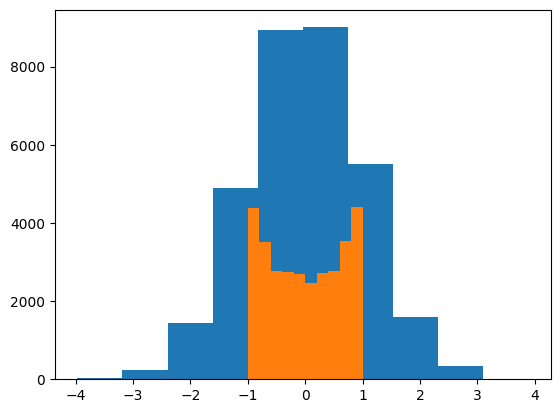

In [75]:
epoch = 500
model = MLP()
losses = []
n_embd = 1000

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
for step in range(epoch):
    X, Y = create_dset("train")
    B, T = X.shape
    C = torch.randn((vocab_size, vocab_size))
    r_m = torch.randn((n_embd,))
    r_s = torch.randn((n_embd,))
    std = torch.zeros((n_embd,))
    mean = torch.ones((n_embd,))
 

    # X = torch.reshape(X, (B, C, T))
    idx = C[X]
    W1 = torch.randn((vocab_size, n_embd))
    b1 = torch.randn((n_embd,))
    idx = idx @ W1 + b1
    B, T, C = idx.shape
    v = idx
    idx = idx.view(B, T, C)
    idx = nn.LayerNorm(n_embd)(idx)
    # idx = idx.view(B,T, C)
    print(idx[0].mean(), idx[0].std())
    plt.hist(idx[0].view(-1).detach().numpy())
    idx = torch.tanh(idx)
    
    plt.hist(idx[0].view(-1).detach().numpy())
    W2 = torch.randn((n_embd, vocab_size))
    b2 = torch.randn((vocab_size,))
    idx = idx @ W2 + b2
    print(idx.shape)
    mean = idx.mean(1, keepdim=True)
    print(decode(X.numpy()[0]), X.shape, idx.shape, mean.shape )
    # logits, loss = model(X, Y) # error with input to batch norm         
    # optimizer.zero_grad(set_to_none=True)
    
    # loss.backward()
    
    # optimizer.step()
    # losses.append(loss.item())
    break

# plt.plot(torch.tensor(losses).log10()), vocab_size